Diffusionsnätverk är äldre än transformer-arkitekturen med några år (2015) men var till en början för prestandamässigt dyr jämfört med GAN. Kring 2020 gjordes ett genombrott (DDPM) och plötsligt blev kvalitén på utdatan lågt mycket bättre än GAN, till de grad att den låga prestandan blev acceptabel.

Diffusion sker i två steg:

Vi börjar med en bild, säg av en katt:

<img src="../Data/diffusion_cat.png" hheight="480"/>

I den framåtriktade processen (_forward process_) läggs brus till från en normalfördelning (gaussian) till bilden i varje steg. 

Vi tränar sedan systemet på den omvända processen!

En komplikation är att vi adaptivt måste minska pixelvärdena, annars blandas inte katten med bruset och bilden når aldrig ett "utsuddat" tillstånd. Koden nedan tar hand om detta, se boken s 733 för detaljer:

In [1]:
import torch

def variance_schedule(T, s=0.008, max_beta=0.999):
    t = torch.linspace(0, T, T + 1)
    f = torch.cos((t / T + s) / (1 + s) * torch.pi / 2) ** 2
    alpha_bars = f / f[0]
    betas = (1 - (f[1:] / f[:-1])).clamp(max=max_beta)
    betas = torch.cat([torch.zeros(1), betas])  # for easier indexing
    alphas = 1 - betas
    return alphas, betas, alpha_bars

torch.manual_seed(42)  # extra code – for reproducibility
T = 4000
alphas, betas, alpha_bars = variance_schedule(T)

Vi behöver förstås bilder också -- importera FashionMNIST igen. Vi passar på att lägga till visningsfunktionerna från förra gången:

In [2]:
import torchvision
import torchvision.transforms.v2 as Tr
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
toTensor = Tr.Compose([Tr.ToImage(), Tr.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])



plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def plot_image(image):
    plt.imshow(image.permute(1, 2, 0).cpu(), cmap="binary")
    plt.axis("off")

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(image)


Forward process:

In [3]:
def forward_diffusion(x0, t):
    eps = torch.randn_like(x0)  # this unscaled noise will be the target
    xt = alpha_bars[t].sqrt() * x0 + (1 - alpha_bars[t]).sqrt() * eps
    return xt, eps

Varje input är en bild och indexet i sekvensen mot utsuddad (som vi kan se som ett tidssteg). 

In [4]:
from collections import namedtuple

class DiffusionSample(namedtuple("DiffusionSampleBase", ["xt", "t"])):
    def to(self, device):
        return DiffusionSample(self.xt.to(device), self.t.to(device))

Vi skapar en dataklass som producerar bilderna när de behövs:

In [5]:
from torch.utils.data import DataLoader

class DiffusionDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, i):
        x0, _ = self.dataset[i]
        x0 = (x0 * 2) - 1  # scale from –1 to +1
        t = torch.randint(1, T + 1, size=[1])
        xt, eps = forward_diffusion(x0, t)
        return DiffusionSample(xt, t), eps

    def __len__(self):
        return len(self.dataset)

train_set = DiffusionDataset(train_data)  # wrap Fashion MNIST
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [6]:
valid_set = DiffusionDataset(valid_data)
valid_loader = DataLoader(valid_set, batch_size=32)

Detta har vi hittils:

Original images


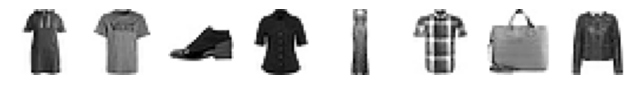

Time steps: [2027, 1463, 3720, 9, 611, 2202, 2118, 388]
Noisy images


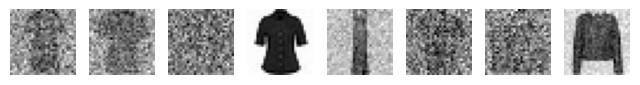

Noise to predict


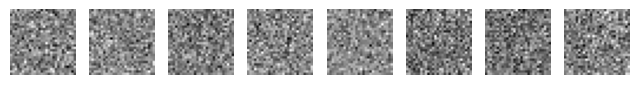

In [7]:
def original_image(sample, noise):
    alpha_bars_t = torch.gather(alpha_bars, dim=0, index=sample.t.squeeze(1))
    alpha_bars_t = alpha_bars_t.view(-1, 1, 1, 1)
    x0 = (sample.xt - (1 - alpha_bars_t).sqrt() * noise) / alpha_bars_t.sqrt()
    return torch.clamp((x0 + 1) / 2, 0, 1)

torch.manual_seed(42)
sample, eps = next(iter(train_loader))  # get the first batch
x0 = original_image(sample, eps).to(device)

print("Original images")
plot_multiple_images(x0[:8])
plt.show()
print("Time steps:", sample.t[:8].view(-1).tolist())
print("Noisy images")
plot_multiple_images(sample.xt[:8])
plt.show()
print("Noise to predict")
plot_multiple_images(eps[:8])
plt.show()



Nu över till själva modellen. Det går i princip att träna vilken modell som helst här, som tar emot en <code>DiffusionSample</code> med en bild. Orginal versionen av DDPM använder U-Net -- ett segmenterande CNN som har visat sig väldigt inflytelserikt. Modellen behöver hantera bilder och deras index i sekvensen, så först en kodning för detta:

In [8]:
import torch.nn as nn

embed_dim = 64

class TimeEncoding(nn.Module):
    def __init__(self, T, embed_dim):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even"
        p = torch.arange(T + 1).unsqueeze(1)
        angle = p / 10_000 ** (torch.arange(0, embed_dim, 2) / embed_dim)
        te = torch.empty(T + 1, embed_dim)
        te[:, 0::2] = torch.sin(angle)
        te[:, 1::2] = torch.cos(angle)
        self.register_buffer("time_encodings", te)

    def forward(self, t):
        return self.time_encodings[t]

U-Net använder samma "trick" som vi såg för konvolutionell GAN; projicera ner i något lägre dimensionellt rum och sedan tillbaka. Bokens version går ett steg längre och har även _skip connections_, dvs residuala kopplingar, som korsar projiceringen. Det är alltså _samtidigt_ en sorts autoencoder! U-Net använder separerbara lager, vilket i princip är en inbyggd ytterligare autoencoder (notera nedan att 'depthwise/pointwise' i princip är en konvolutionell självkodare).

In [9]:
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size,
                                   padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, X):
        return self.pointwise(self.depthwise(X))

class DiffusionModel(nn.Module):
    def __init__(self, T=T, embed_dim=64):
        super().__init__()
        self.time_encoding = TimeEncoding(T, embed_dim)

        # Init
        dim = 16
        self.pad = nn.ConstantPad2d((3, 3, 3, 3), 0)
        self.init_conv = nn.Conv2d(1, dim, kernel_size=3)
        self.init_bn = nn.BatchNorm2d(dim)
        self.time_adapter_init = nn.Linear(embed_dim, dim)

        # Down path
        self.down_blocks = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.time_adapters_down = nn.ModuleList()
        in_dim = dim
        for dim in (32, 64, 128):
            block = nn.Sequential(
                nn.ReLU(),
                SeparableConv2d(in_dim, dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                SeparableConv2d(dim, dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim)
            )
            skip_conv = nn.Conv2d(in_dim, dim, kernel_size=1, stride=2)
            self.down_blocks.append(block)
            self.skip_convs.append(skip_conv)
            self.time_adapters_down.append(nn.Linear(embed_dim, dim))
            in_dim = dim

        # Up path
        self.up_blocks = nn.ModuleList()
        self.skip_up_convs = nn.ModuleList()
        self.time_adapters_up = nn.ModuleList()
        for dim in (64, 32, 16):
            block = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(in_dim, dim, 3, padding=1),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                nn.ConvTranspose2d(dim, dim, 3, padding=1),
                nn.BatchNorm2d(dim)
            )
            skip_conv = nn.Conv2d(in_dim, dim, kernel_size=1)
            self.up_blocks.append(block)
            self.skip_up_convs.append(skip_conv)
            self.time_adapters_up.append(nn.Linear(embed_dim, dim))
            in_dim = dim * 3  # because of concatenation with cross skip

        self.final_conv = nn.Conv2d(in_dim, 1, 3, padding=1)

    def forward(self, sample):
        if not isinstance(sample, DiffusionSample):
            print(repr(sample))
        time_enc = self.time_encoding(sample.t.squeeze(1))  # [batch, embed_dim]
        z = self.pad(sample.xt)
        z = F.relu(self.init_bn(self.init_conv(z)))
        z = z + self.time_adapter_init(time_enc)[:, :, None, None]
        skip = z
        cross_skips = []

        # Downsampling path
        for block, skip_conv, time_adapter in zip(
                self.down_blocks, self.skip_convs, self.time_adapters_down):
            z = block(z)
            cross_skips.append(z)
            z = F.max_pool2d(z, 3, stride=2, padding=1)
            skip_link = skip_conv(skip)
            z = z + skip_link
            z = z + time_adapter(time_enc)[:, :, None, None]
            skip = z

        # Upsampling path
        for block, skip_up_conv, time_adapter in zip(
                self.up_blocks, self.skip_up_convs, self.time_adapters_up):
            z = block(z)
            z = F.interpolate(z, scale_factor=2, mode="nearest")
            skip_link = F.interpolate(skip, scale_factor=2, mode="nearest")
            skip_link = skip_up_conv(skip_link)
            z = z + skip_link
            z = z + time_adapter(time_enc)[:, :, None, None]
            cross_skip = cross_skips.pop()
            z = torch.cat([z, cross_skip], dim=1)
            skip = z

        out = self.final_conv(z)
        out = out[:, :, 2:-2, 2:-2]  # cropping
        return out.contiguous()

Samma träningsfunktion som tidigare (från boken):

In [10]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=2, factor=0.5, epoch_callback=None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=patience, factor=factor)
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        if epoch_callback is not None:
            epoch_callback(model, epoch)
        for index, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
            train_metric = metric.compute().item()
            print(f"\rBatch {index + 1}/{len(train_loader)}", end="")
            print(f", loss={total_loss/(index+1):.4f}", end="")
            print(f", {train_metric=:.3f}", end="")
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        if (epoch % 100 == 0): 
            torch.save(model, f"./diffusion_{epoch}.pt")
        print(f"\rEpoch {epoch + 1}/{n_epochs},                      "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.3}, "
              f"valid metric: {history['valid_metrics'][-1]:.3}")
    return history



Träningsdags!

In [ ]:
torch.manual_seed(42)
diffusion_model = DiffusionModel().to(device)
huber = nn.HuberLoss()
optimizer = torch.optim.NAdam(diffusion_model.parameters(), lr=3e-3)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(diffusion_model, optimizer, huber, rmse, train_loader,
                valid_loader, n_epochs=20)



Epoch 1/600,                      train loss: 0.0672, train metric: 0.38, valid metric: 0.333
Epoch 2/600,                      train loss: 0.0477, train metric: 0.319, valid metric: 0.314
Epoch 3/600,                      train loss: 0.0842, train metric: 1.04, valid metric: 0.308
Epoch 4/600,                      train loss: 0.0440, train metric: 0.306, valid metric: 0.3
Epoch 5/600,                      train loss: 0.0417, train metric: 0.298, valid metric: 0.295
Epoch 6/600,                      train loss: 0.0413, train metric: 0.296, valid metric: 0.297
Epoch 7/600,                      train loss: 0.0411, train metric: 0.296, valid metric: 0.292
Epoch 8/600,                      train loss: 0.0404, train metric: 0.294, valid metric: 0.295
Epoch 9/600,                      train loss: 0.0401, train metric: 0.292, valid metric: 0.293
Epoch 10/600,                      train loss: 0.0402, train metric: 0.293, valid metric: 0.289
Epoch 11/600,                      train loss: 0.0394

Träningen är relativt snabb, men genereringen förhållandevis långsam.

In [16]:
def generate_ddpm(model, batch_size=32):
    model.eval()
    with torch.no_grad():
        xt = torch.randn([batch_size, 1, 28, 28], device=device)
        for t in range(T, 0, -1):
            print(f"\rt = {t}", end=" ")  # extra code — show progress
            alpha_t = alphas[t]
            beta_t = betas[t]
            alpha_bar_t = alpha_bars[t]
            noise = (torch.randn(xt.shape, device=device)
                     if t > 1 else torch.zeros(xt.shape, device=device))
            t_batch = torch.full((batch_size, 1), t, device=device)
            sample = DiffusionSample(xt, t_batch)
            eps_pred = model(sample)
            xt = (1 / alpha_t.sqrt()
                  * (xt - beta_t / (1 - alpha_bar_t).sqrt() * eps_pred)
                  + (1 - alpha_t).sqrt() * noise)
        return torch.clamp((xt + 1) / 2, 0, 1)

torch.manual_seed(42)  # extra code – ensures reproducibility
X_gen = generate_ddpm(diffusion_model)  # generated images

t = 1    

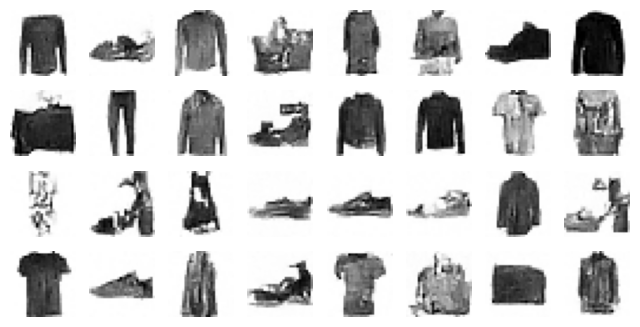

In [17]:
plot_multiple_images(X_gen, 8)
plt.show()

Resultaten är imponerande med tanke på träninsgtiden! Däremot kommer vi ändå inte så mycket längre med FashionMNIST och utan attention lager i U-Net implementationen. Nätverket behöver tränas på större bilder med högre upplösning och fler detaljer. Det finns också en effektivare metod att generera bilderna från en DDPM modell; DDIM. Prestandan är en storleksordning bättre, från ~4s till 0.4s. 

In [18]:
def generate_ddim(model, batch_size=32, num_steps=50, eta=0.85):
    model.eval()
    with torch.no_grad():
        xt = torch.randn([batch_size, 1, 28, 28], device=device)
        times = torch.linspace(T - 1, 0, steps=num_steps + 1).long().tolist()
        for t, t_prev in zip(times[:-1], times[1:]):
            print(f"\rt = {t}", end=" ")
            t_batch = torch.full((batch_size, 1), t, device=device)
            sample = DiffusionSample(xt, t_batch)
            eps_pred = model(sample)
            x0 = ((xt - (1 - alpha_bars[t]).sqrt() * eps_pred)
                  / (alpha_bars[t].sqrt()))
            abar_t_prev = alpha_bars[t_prev]
            variance = eta * (1 - abar_t_prev) / (1 - alpha_bars[t]) * betas[t]
            sigma_t = variance.sqrt()
            pred_dir = (1 - abar_t_prev - sigma_t**2).sqrt() * eps_pred
            noise = torch.randn_like(xt)
            xt = abar_t_prev.sqrt() * x0 + pred_dir + sigma_t * noise

        return torch.clamp((xt + 1) / 2, 0, 1)  # from [–1, 1] range to [0, 1]

torch.manual_seed(42)  # extra code – ensures reproducibility
X_gen_ddim = generate_ddim(diffusion_model, num_steps=1000)

t = 3    

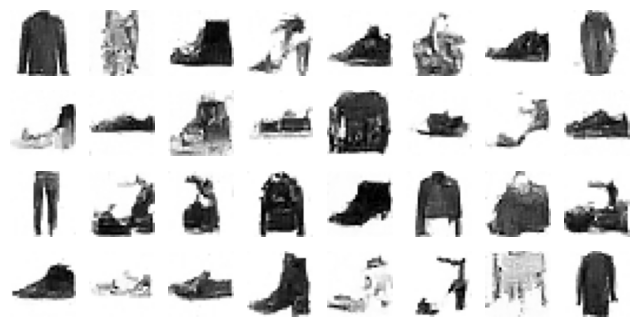

In [19]:
plot_multiple_images(X_gen_ddim, 8)
plt.show()

En fullt ut optimerad diffusionsmodell kan ge mer imponerande resultat, här ett färdigpaketerat exempel på en multimodal modell, Stable-Diffusion Turbo. 

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You are using a model of type clip_text_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/1 [00:00<?, ?it/s]

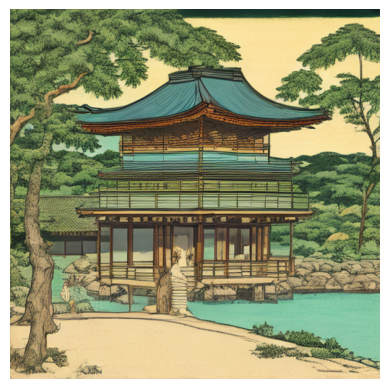

In [41]:
from diffusers import AutoPipelineForText2Image

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sd-turbo", variant="fp16", dtype=torch.float16)
pipe.to(device)
prompt = "A pavilion by the water, ukiyo-e style"

for image in pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[:]:
        plt.imshow(image)
        plt.axis("off")
        
plt.show()

